# A Basic Model From Scratch

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim

## The Data

For this exercies I generated some "known" measurments in Celcius, along with some measurments in "uknown" units.

My goal wil be to build a machine learning model from scratch that will illustrate how the process works to learn a pattern from this data to create a model.

In [2]:
# Create a RandomState object with a fixed seed
rng = np.random.RandomState(123321)

## Know values
t_c = rng.rand(25) * 50 - 10

## Unknown units
#°F = (°C × 9/5) + 32 + noise
noise = rng.rand(len(t_c))*10
t_u = t_c*(9/5) + 32 + noise

t_c, t_u

(array([ 5.03356657, -7.98138469,  4.53049724, 30.24444581,  7.35333754,
        22.0157944 , 26.88121566, -4.13897886, 19.66998732, 29.09237518,
        21.64986101, 34.14616679,  1.80137919, 18.27952206, 24.25068514,
        30.14273335, 39.50004755,  8.05017639, -0.29200168,  7.27663439,
        14.83958112,  2.05180527, -1.58816538, 24.31357713, 37.35457721]),
 array([ 44.19702019,  22.71345066,  43.88393846,  91.91828031,
         47.42799008,  74.2023766 ,  84.13480626,  32.20427345,
         68.82432007,  85.59787032,  72.58815838, 101.79763141,
         35.62048155,  68.14499618,  81.45230932,  88.19749461,
        110.3228576 ,  52.79852288,  37.32248766,  47.42045894,
         64.73860393,  42.75027874,  37.98040589,  79.70736574,
        103.24227032]))

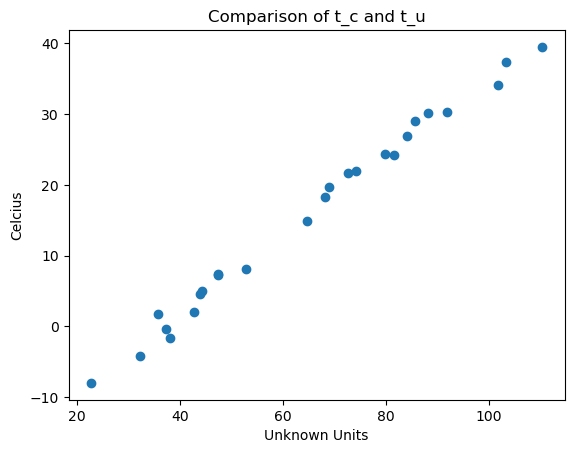

In [3]:
## Plot the data
plt.scatter(t_u,t_c)
plt.xlabel("Unknown Units")
plt.ylabel("Celcius")
plt.title("Comparison of t_c and t_u")
plt.show()

In [4]:
## Prepare the data
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

## A Linear Model
Our first guess would probably be that this is a linear model. (We did fabricate the data, but lets pretend we don't know that.)

In [5]:
## Define the basic model: linear
def model(t_u, w, b):
    ## t_u : input tensor
    ## w : weights
    ## b : bias
    return w*t_u + b

## Define a loss function: mean squared loss
def loss_fn(t_p, t_c):
    ## t_p : predicted values
    ## t_c : true values
    squared_diffs = (t_p-t_c)**2
    return squared_diffs.mean()

## Initialize weights and bias
w = torch.ones(())
b = torch.zeros(())

## Make a prediction
t_p = model(t_u, w, b)
t_p

tensor([ 44.1970,  22.7135,  43.8839,  91.9183,  47.4280,  74.2024,  84.1348,
         32.2043,  68.8243,  85.5979,  72.5882, 101.7976,  35.6205,  68.1450,
         81.4523,  88.1975, 110.3229,  52.7985,  37.3225,  47.4205,  64.7386,
         42.7503,  37.9804,  79.7074, 103.2423], dtype=torch.float64)

In [6]:
## Compute the loss
loss = loss_fn(t_p, t_c)
loss

tensor(2519.0371, dtype=torch.float64)

## Optimizing loss using gradient descent

Lets do this again, but using autograd for gradient descent

In [7]:
## Define the basic model: linear
def model(t_u, w, b):
    ## t_u : input tensor
    ## w : weights
    ## b : bias
    return w * t_u + b

## Define a loss function: mean squared loss
def loss_fn(t_p, t_c):
    ## t_p : predicted values
    ## t_c : true values
    squared_diffs = (t_p-t_c)**2
    return squared_diffs.mean()

## Initialize weights and bias so that they can keep track of gradient
params = torch.tensor([1.0, 0.0], requires_grad=True)

In [8]:
## Make a prediction
t_p = model(t_u, *params)

## Compute the loss
loss = loss_fn(t_p, t_c)

## Compute the gradient of loss at t_p
loss.backward()

## Observe the value of the gradient
params.grad

tensor([6875.6050,   97.9769])

In [9]:
## RESET GRAD TO ZERO (so it doesn't just keep accumulating)
if params.grad is not None:
    params.grad.zero_()

### Defining a Training Loop
Now that we hae access to the gradient, we can use it to optimize our parameters

In [10]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    ## In each epoch
    for epoch in range(1, n_epochs+1):
        ## Reset the gradient, if needed
        if params.grad is not None:
            params.grad.zero_()
        ## Make a prediction
        t_p = model(t_u, *params)
        ## Compute the loss
        loss = loss_fn(t_p, t_c)
        ## Compute the gradient
        loss.backward()
        ## Update the params
        with torch.no_grad(): ## Don't autograd at this step
            params -= learning_rate*params.grad

        ## Output progress
        if epoch%250==0:
            print(f"Epoch: {epoch}, Loss: {float(loss)}")
    
    return params

### Scaling the Data and Running the Model
We observed a huge difference in gradient values between the weight and bias components of the gradient. We can help reduce the impact of this disparity (so that steps by a given learning rate will have similar impacts on each component) by simply scaling the data.

In [11]:
## Scale the input data
t_un = 0.1*t_u

## Train the model
learned_params = training_loop(
    n_epochs=5000,
    learning_rate=1e-2,
    params=torch.tensor([1.0,0.0], requires_grad=True),
    t_u = t_un, ## Use the normalized data
    t_c = t_c
)

Epoch: 250, Loss: 17.185363715461005
Epoch: 500, Loss: 6.249424989865812
Epoch: 750, Loss: 3.040183999773908
Epoch: 1000, Loss: 2.098402639131146
Epoch: 1250, Loss: 1.8220321756930966
Epoch: 1500, Loss: 1.7409291390060764
Epoch: 1750, Loss: 1.7171283296832502
Epoch: 2000, Loss: 1.7101440036343578
Epoch: 2250, Loss: 1.7080943282089192
Epoch: 2500, Loss: 1.7074928472615216
Epoch: 2750, Loss: 1.7073163676153729
Epoch: 3000, Loss: 1.7072645814663436
Epoch: 3250, Loss: 1.7072493823992352
Epoch: 3500, Loss: 1.707244920785241
Epoch: 3750, Loss: 1.7072436045962625
Epoch: 4000, Loss: 1.7072432149853094
Epoch: 4250, Loss: 1.7072431092339673
Epoch: 4500, Loss: 1.7072430751419925
Epoch: 4750, Loss: 1.7072430751419925
Epoch: 5000, Loss: 1.7072430751419925


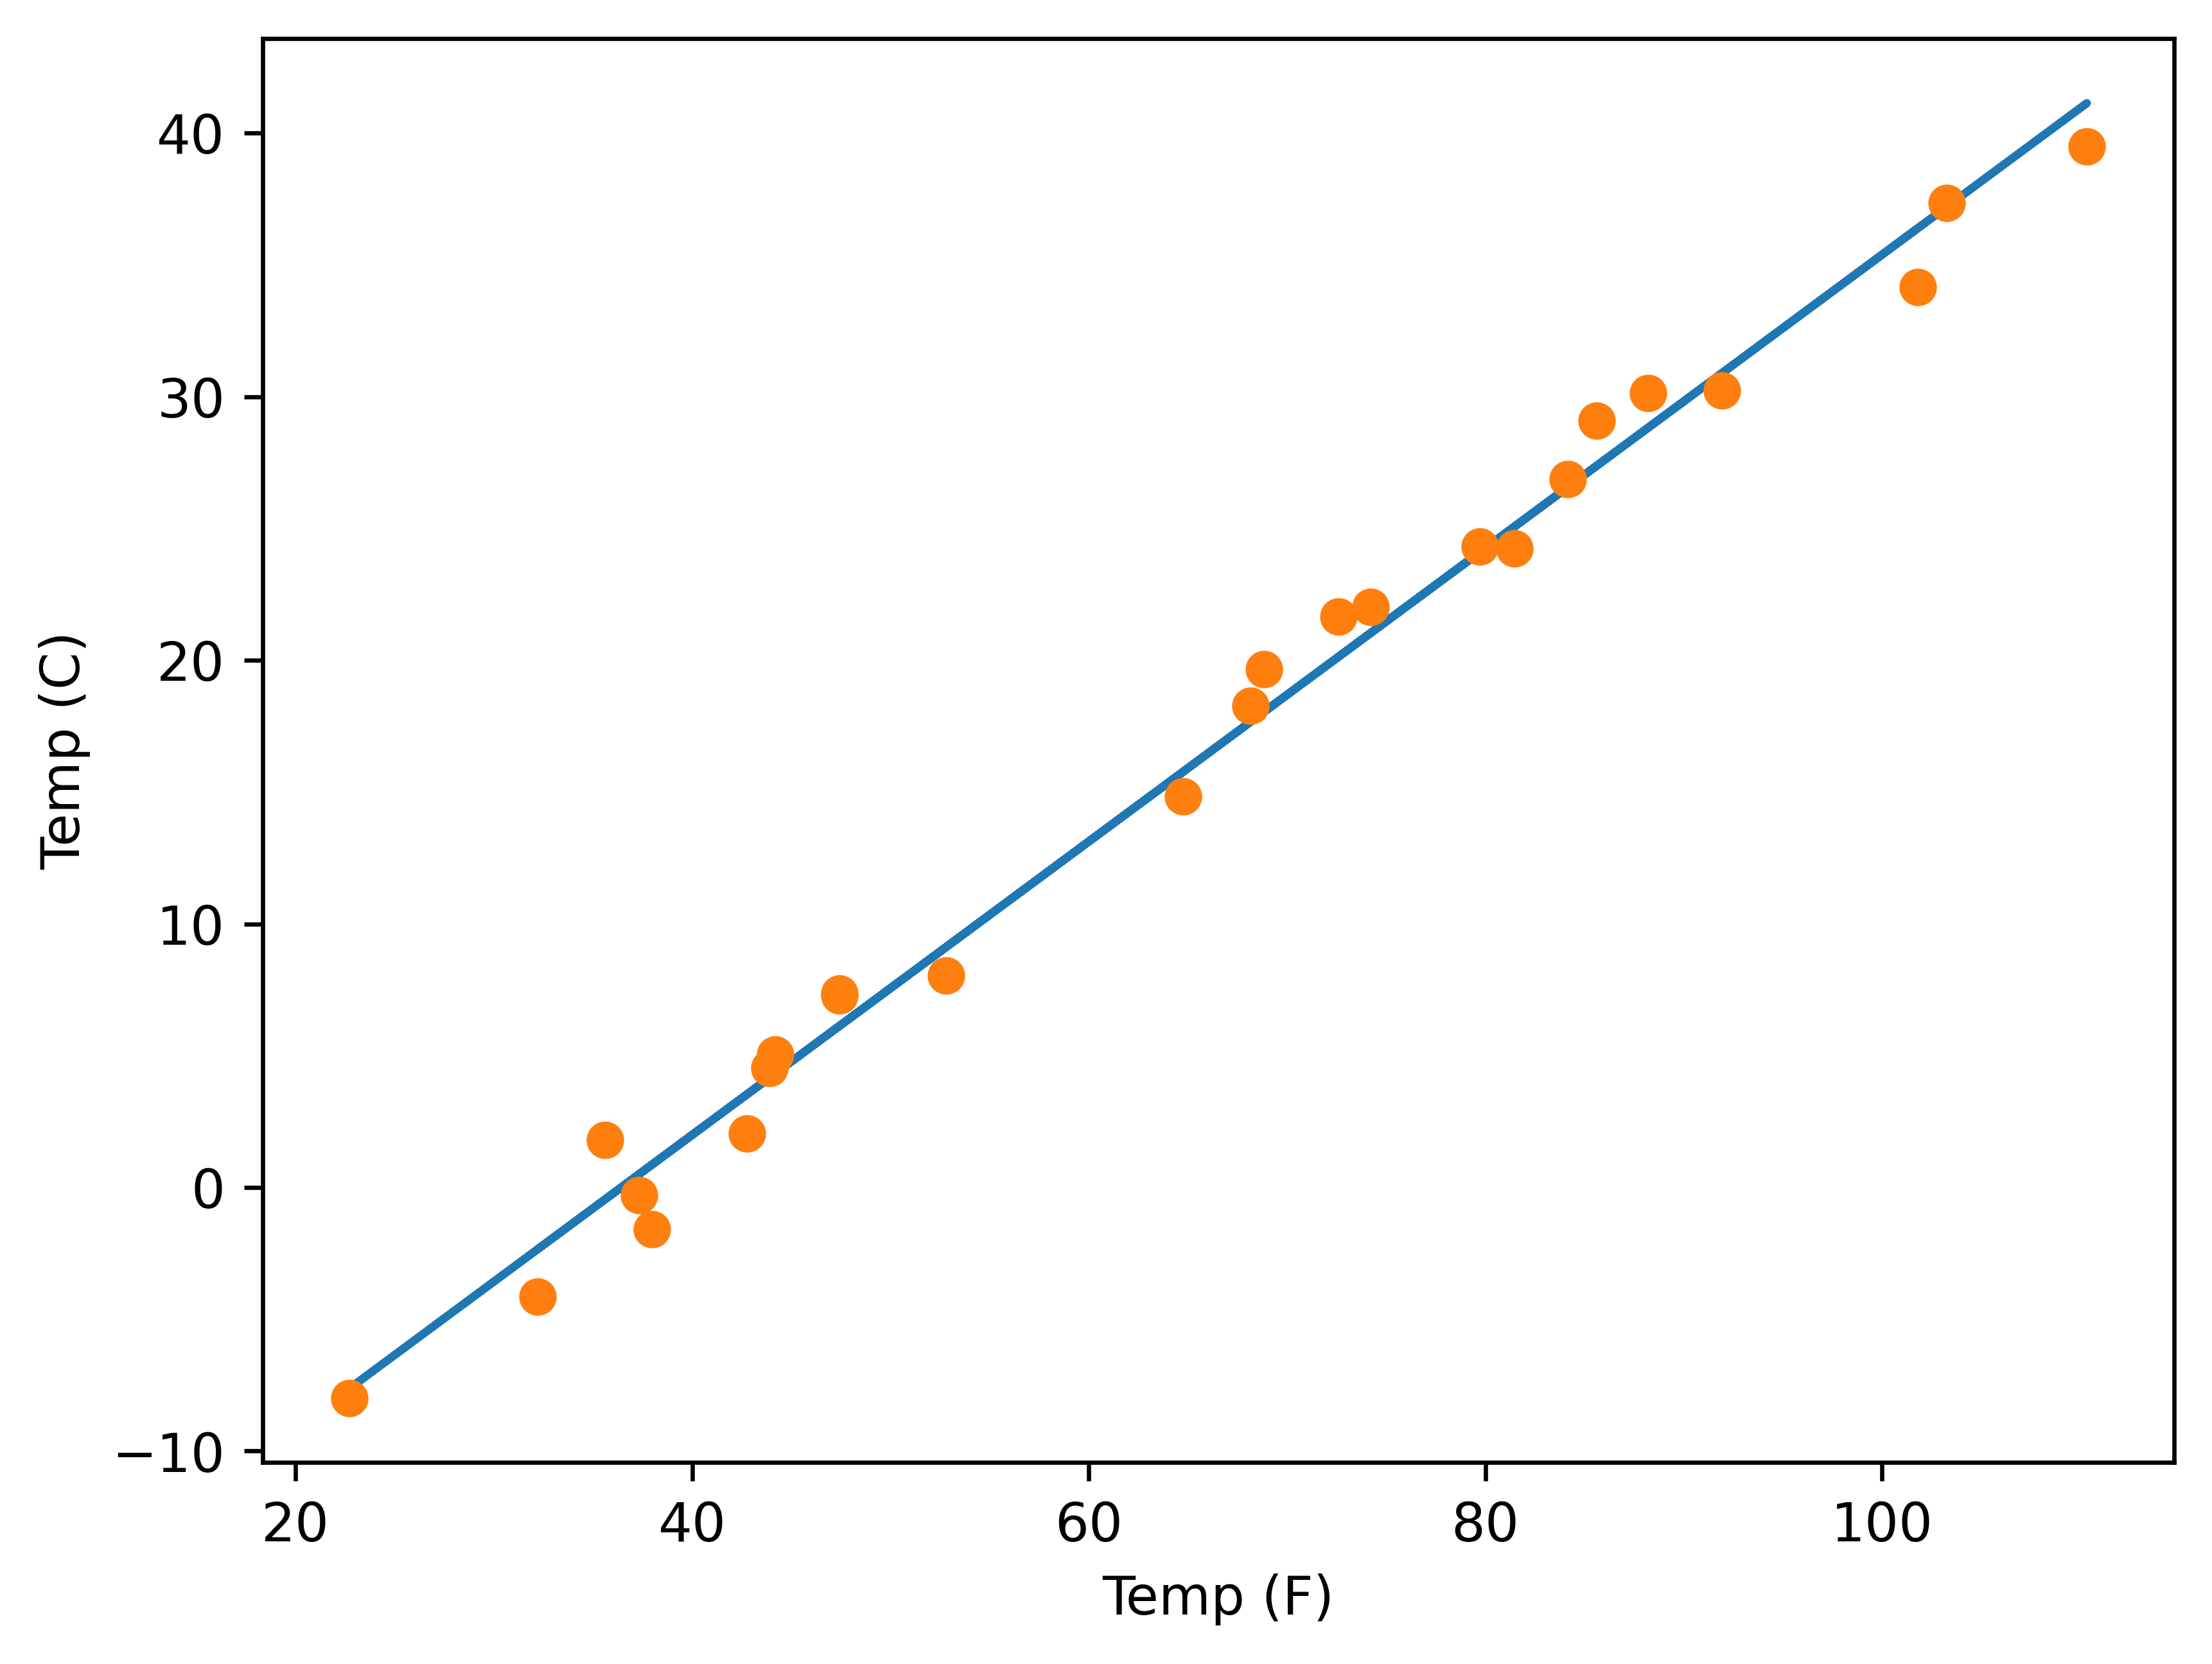

In [12]:
## Plot the results
t_p = model(t_un, *learned_params)
fig = plt.figure(dpi=600)
plt.xlabel("Temp (F)")
plt.ylabel("Temp (C)")
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.show()

In [13]:
learned_params

tensor([  5.5664, -20.2733], requires_grad=True)

## Built in Optimizers and a Validation Set

Here's how we might use built in optimizer and validation set to measure our progress while also monitoring validation loss (to avoid overfitting).

In [15]:
## What optimizer as available?
dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'NAdam',
 'Optimizer',
 'RAdam',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional',
 '_multi_tensor',
 'lr_scheduler',
 'swa_utils']

In [27]:
## Get the number of samples
n_samples = t_u.shape[0]

## Determine the size of the validation set
n_val = int(0.2*n_samples)

## Grab n_val random examples from the samples for validation
shuffled_indices = torch.randperm(n_samples)
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

## Gather up training and validation sets
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

## Normalize the input data
t_un_train = 0.01 * t_u_train
t_un_val = 0.01 * t_u_val

## Initialize the parameters
params = torch.tensor([1.0, 0.0], requires_grad=True)

## Set up an optimizer
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

## Modify the training loop to evaluate on the validation set
def training_loop(n_epochs, 
                  optimizer, 
                  params, 
                  t_u_train, t_c_train,
                  t_u_val, t_c_val):

    ## In each epoch
    for epoch in range(1, n_epochs+1):
        ## Make predictions on training data
        t_p_train = model(t_u_train, *params)
        ## Compute the loss on the training data
        train_loss = loss_fn(t_p_train, t_c_train)
        
        ## When validating, we don't want to update the gradient
        with torch.no_grad():
            ## Make predictions and compute loss on the validation data
            t_p_val = model(t_u_val, *params)
            val_loss = loss_fn(t_p_val, t_c_val)
            ## Make sure val_loss is not messing with the gradient
            assert val_loss.requires_grad == False
        
        ## Zero out the gradient
        optimizer.zero_grad()
        ## Compute gradient of loss at current prediction
        train_loss.backward()
        ## Let the optimizer handle parameter updates
        optimizer.step()

        ## Output progress
        if (epoch <= 5) or (epoch % 250 == 0):
            print(f"Epoch: {epoch}, Training Loss: {float(train_loss)}, Validation Loss: {float(val_loss)}")
    
    return params

In [28]:
## Train the model
learned_params = training_loop(
    n_epochs=5000,
    optimizer=optimizer,
    params=params,
    t_u_train=t_un_train, ## Use the normalized data
    t_c_train=t_c_train,
    t_u_val=t_un_val,
    t_c_val=t_c_val
)

Epoch: 1, Training Loss: 387.0695092298987, Validation Loss: 497.92827093866765
Epoch: 2, Training Loss: 373.5551665196144, Validation Loss: 478.9473167545787
Epoch: 3, Training Loss: 360.7771764755515, Validation Loss: 460.90127971185666
Epoch: 4, Training Loss: 348.6946943120344, Validation Loss: 443.74146376243925
Epoch: 5, Training Loss: 337.26913953230803, Validation Loss: 427.42177924305196
Epoch: 250, Training Loss: 96.52464500060476, Validation Loss: 55.99382201014758
Epoch: 500, Training Loss: 62.97359203976255, Validation Loss: 33.35860444770471
Epoch: 750, Training Loss: 41.293834526034615, Validation Loss: 19.479417227962706
Epoch: 1000, Training Loss: 27.284944475666947, Validation Loss: 11.065503394097258
Epoch: 1250, Training Loss: 18.23273007113036, Validation Loss: 6.074286772631681
Epoch: 1500, Training Loss: 12.383354150337663, Validation Loss: 3.207300962589012
Epoch: 1750, Training Loss: 8.60368613956347, Validation Loss: 1.6427316338877922
Epoch: 2000, Training Lo

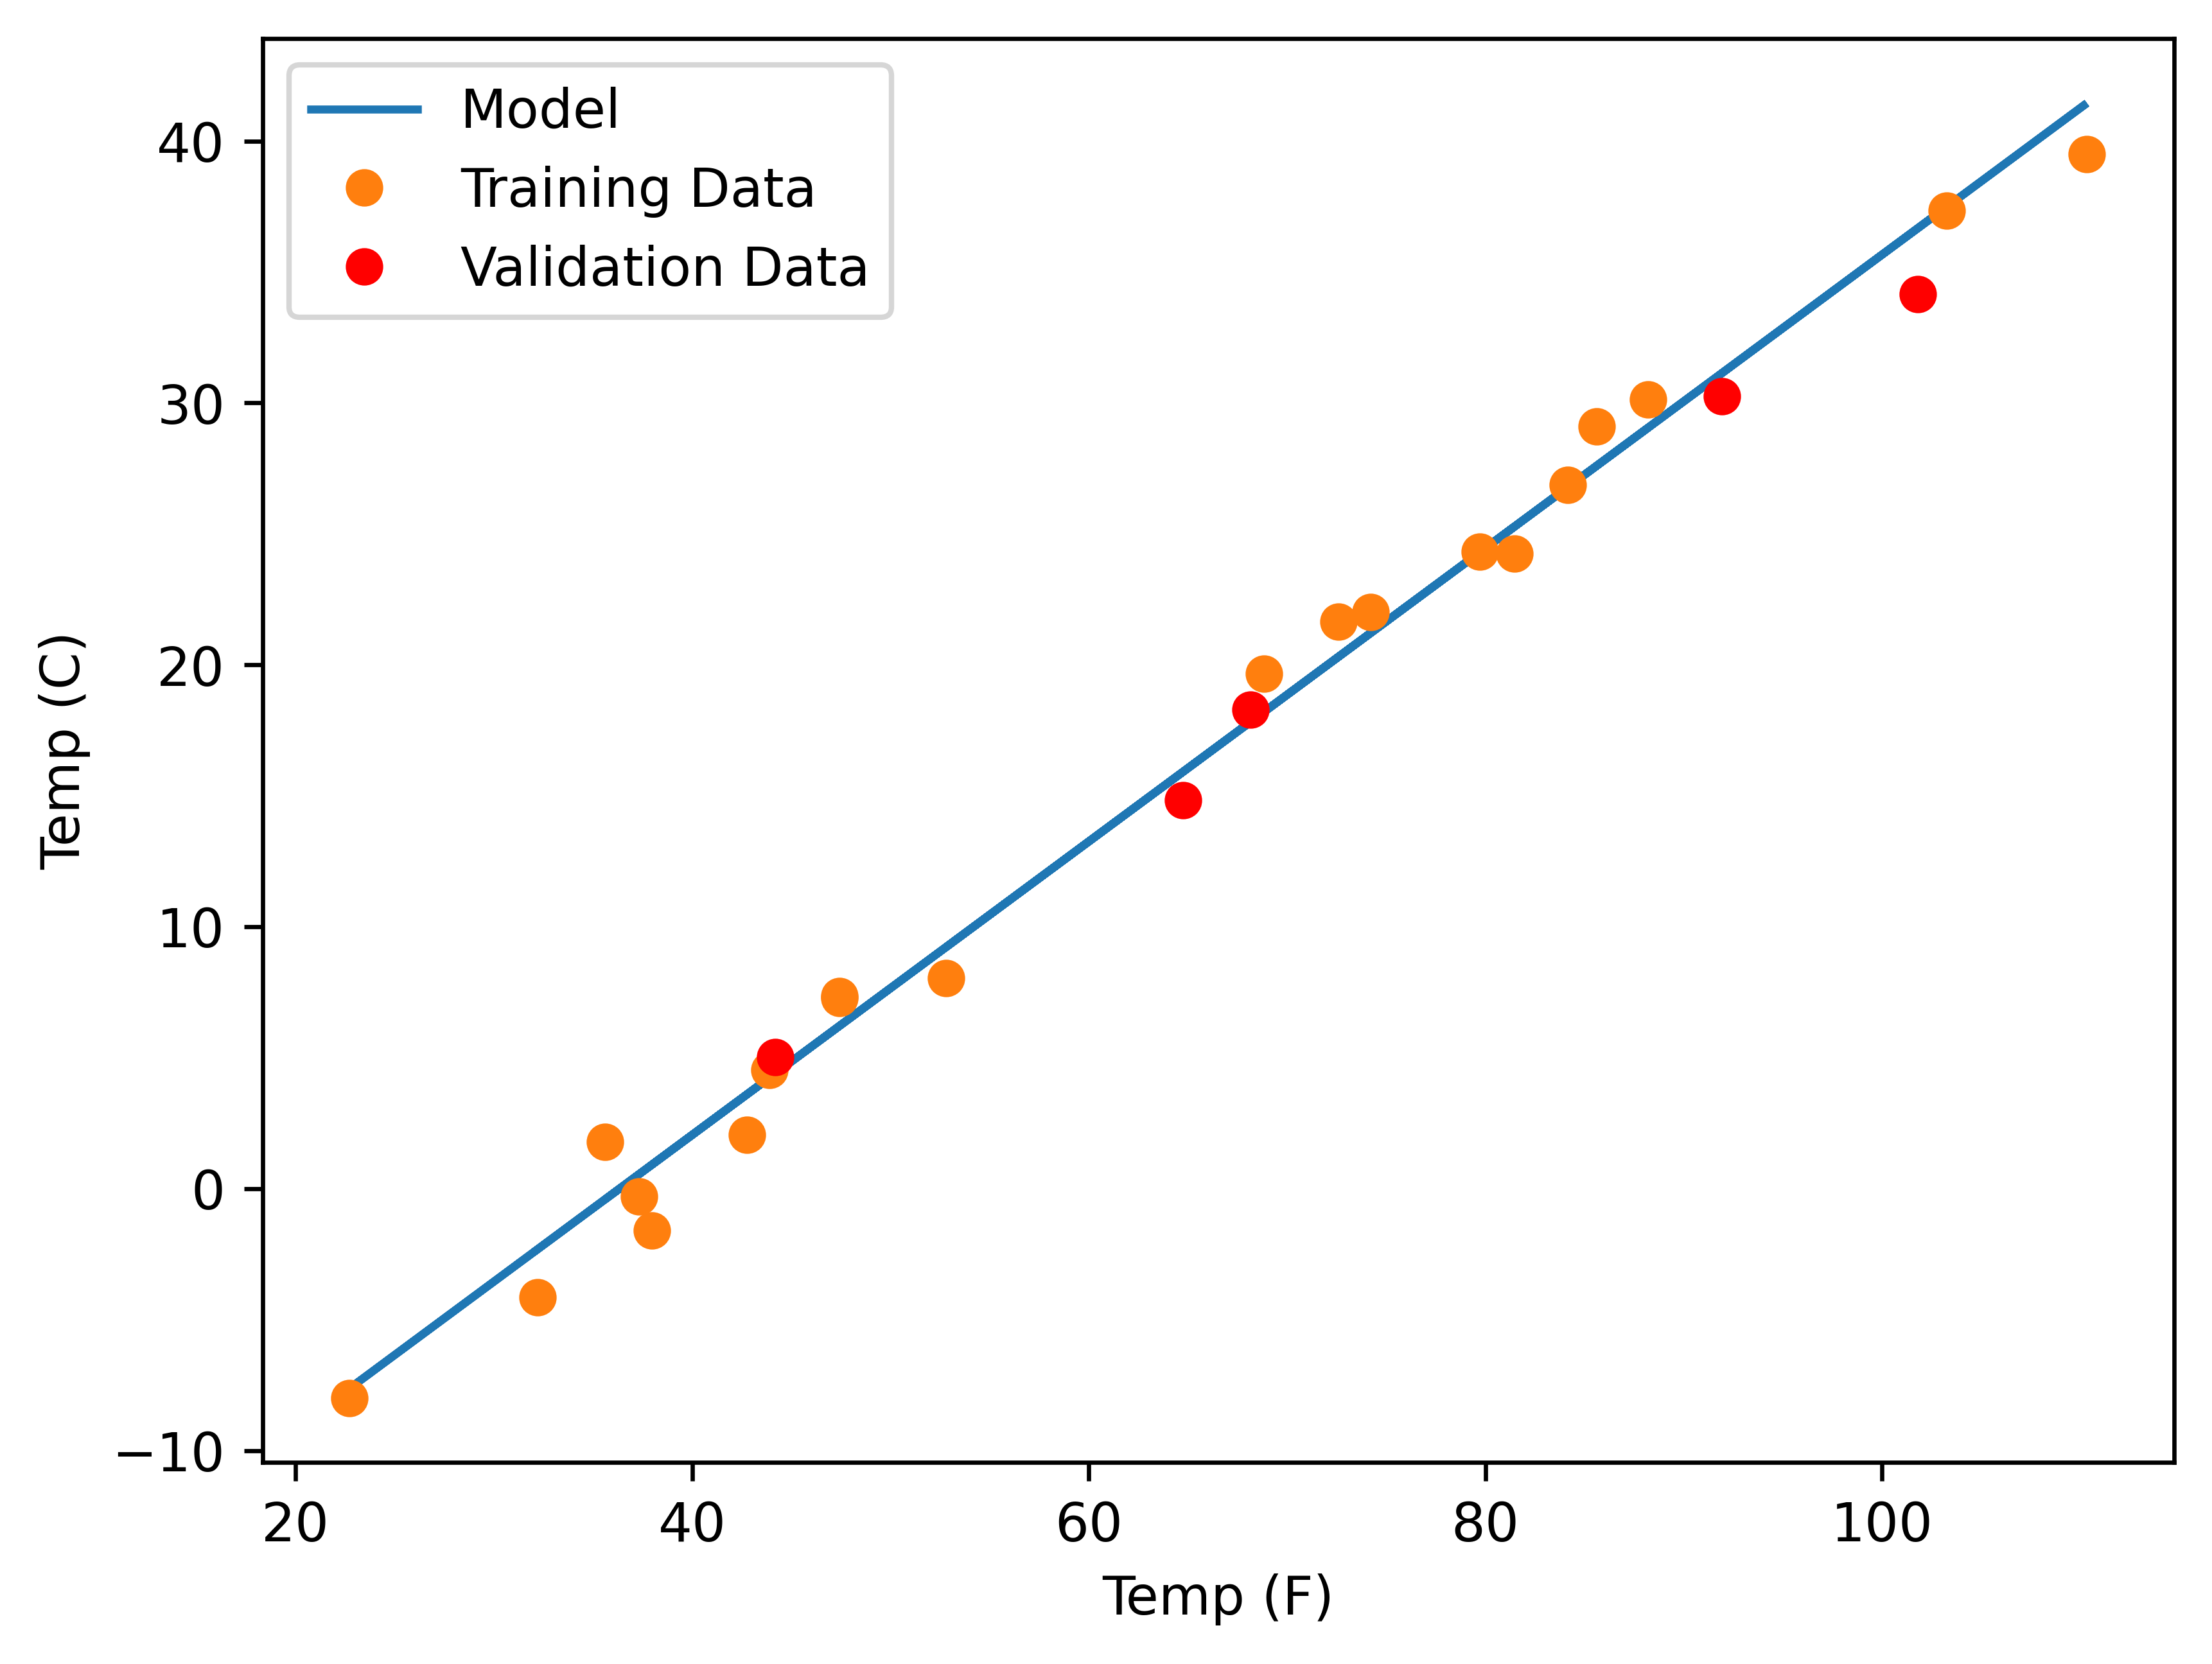

In [30]:
## Plot the results
t_p_train = model(t_un_train, *learned_params)
fig = plt.figure(dpi=600)
plt.xlabel("Temp (F)")
plt.ylabel("Temp (C)")
plt.plot(t_u_train.numpy(), t_p_train.detach().numpy(), label="Model")
plt.plot(t_u_train.numpy(), t_c_train.numpy(), 'o', label="Training Data")
plt.plot(t_u_val.numpy(), t_c_val.numpy(), 'ro', label="Validation Data")
plt.legend()
plt.show()